## Reproduce COVID-NET 

Christine Swisher 
April 12, 2020

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from scipy import interp
from itertools import cycle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../COVID-Net/results_probs.csv')[['preds','labels','normal','pneumonia','covid']]
y_test = df.labels
pred = df.preds
df.head()

,preds,labels,normal,pneumonia,covid
0,2,1,0.020603,0.029692,0.949705
1,1,1,0.000740,0.998678,0.000582
2,1,1,0.000770,0.999145,0.000085
3,1,1,0.000741,0.998580,0.000679
4,1,1,0.000072,0.998898,0.001030


In [3]:
df.labels.value_counts()

1    137
0     90
2     20
Name: labels, dtype: int64

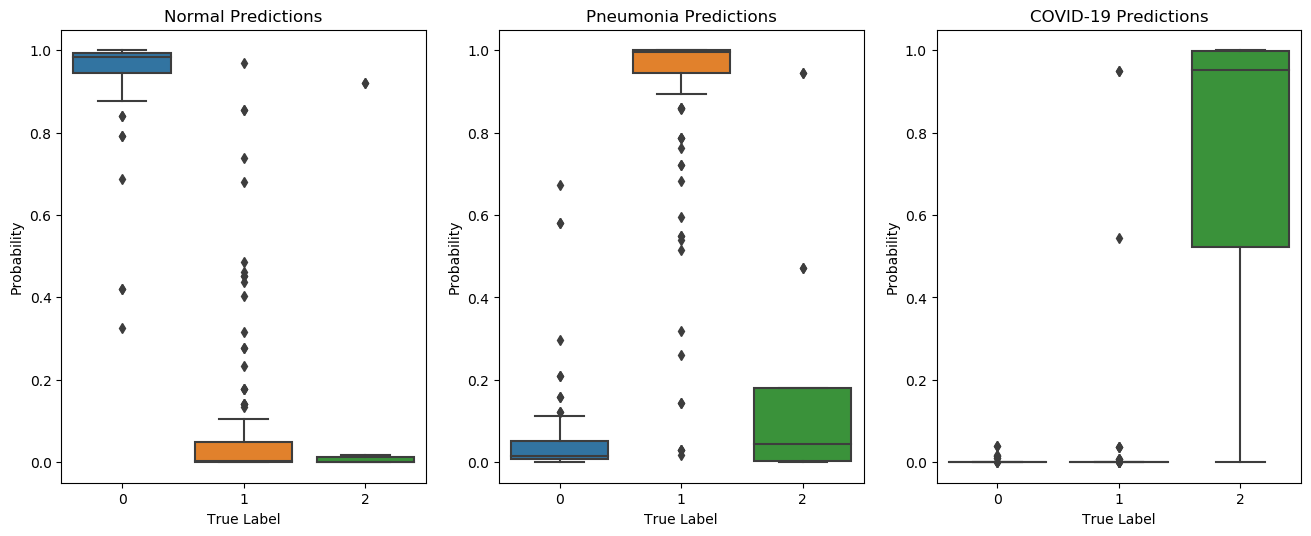

In [4]:
plt.figure(figsize=(16,6), dpi=100)
plt.subplot(131)
sns.boxplot(x="labels", y="normal", data=df)
plt.xlabel('True Label')
plt.ylabel('Probability')
plt.title('Normal Predictions')

plt.subplot(132)
sns.boxplot(x="labels", y="pneumonia", data=df)
plt.xlabel('True Label')
plt.ylabel('Probability')
plt.title('Pneumonia Predictions')

plt.subplot(133)
sns.boxplot(x="labels", y="covid", data=df)
plt.xlabel('True Label')
plt.ylabel('Probability')
plt.title('COVID-19 Predictions')
plt.show()

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


class_names = ['normal', 'pneumonia', 'covid']
n_classes = len(class_names)

y = label_binarize(df['labels'], classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], df[class_names[i]])
    roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


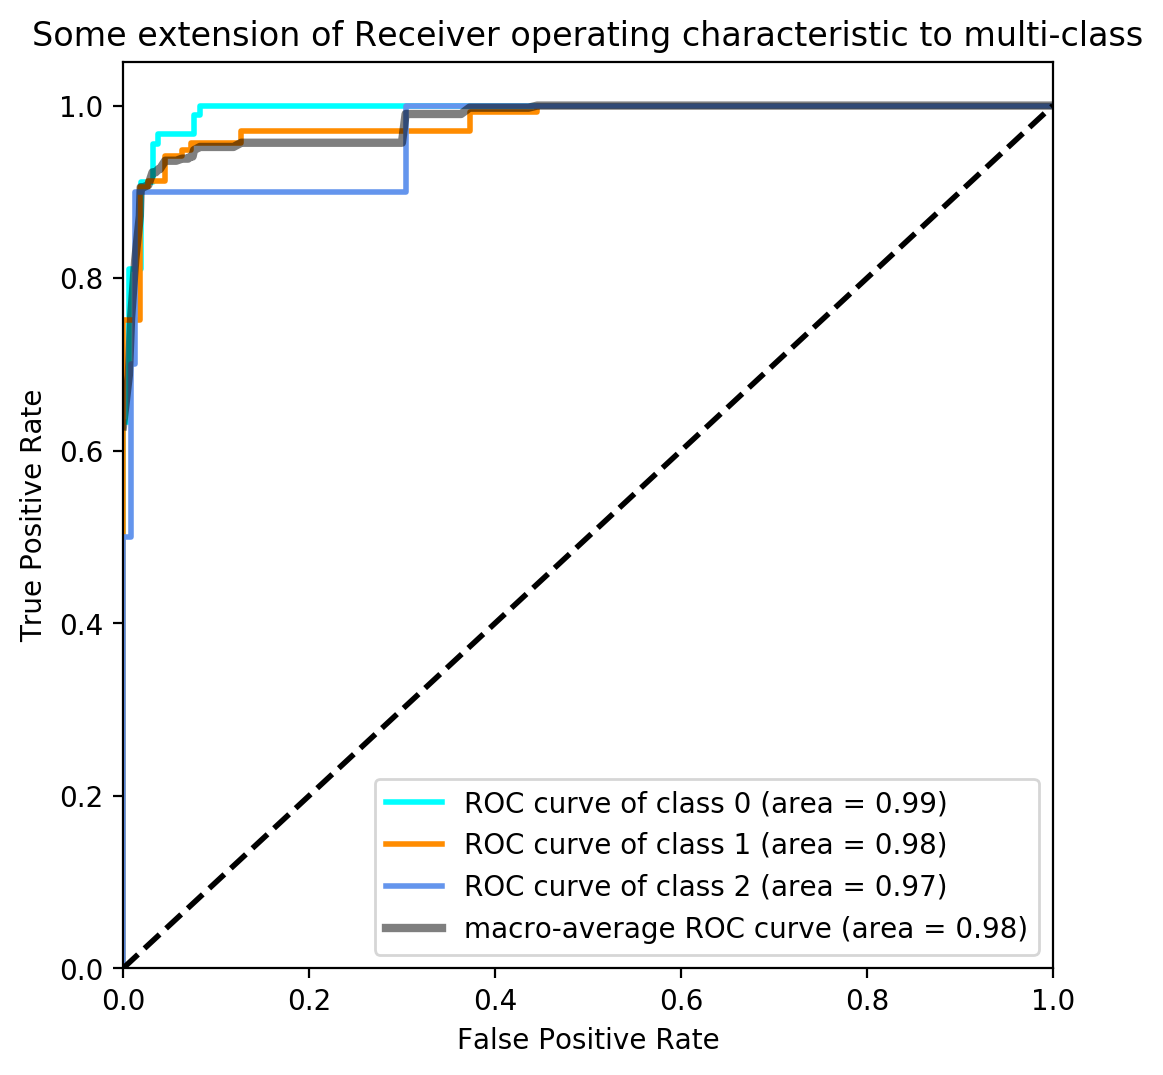

In [6]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2
    
# Plot all ROC curves
plt.figure(figsize=(6,6), dpi =200)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='black', alpha = 0.5, linestyle='-', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

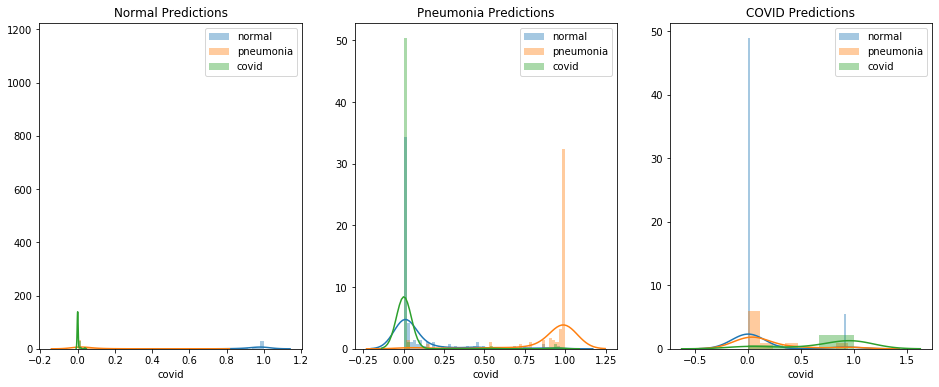

In [7]:
plt.figure(figsize=(16,6))
plt.subplot(131)
sns.distplot(df.normal[df.labels == 0],    label = 'normal')
sns.distplot(df.pneumonia[df.labels == 0], label = 'pneumonia')
sns.distplot(df.covid[df.labels == 0],     label = 'covid')
plt.title('Normal Predictions')
# plt.yscale('log')
plt.legend()

plt.subplot(132)
sns.distplot(df.normal[df.labels == 1],    label = 'normal')
sns.distplot(df.pneumonia[df.labels == 1], label = 'pneumonia')
sns.distplot(df.covid[df.labels == 1],     label = 'covid')
plt.title('Pneumonia Predictions')
# plt.yscale('log')
plt.legend()

plt.subplot(133)
sns.distplot(df.normal[df.labels == 2],    label = 'normal')
sns.distplot(df.pneumonia[df.labels == 2], label = 'pneumonia')
sns.distplot(df.covid[df.labels == 2],     label = 'covid')
# plt.yscale('log')
plt.title('COVID Predictions')
plt.legend()
plt.show()

In [8]:
matrix = confusion_matrix(y_test, pred)
matrix = matrix.astype('float')
    #cm_norm = matrix / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
    #class_acc = np.array(cm_norm.diagonal())
class_acc = [matrix[i,i]/np.sum(matrix[i,:]) if np.sum(matrix[i,:]) else 0 for i in range(len(matrix))]
print('Sens Normal: {0:.3f}, Pneumonia: {1:.3f}, COVID-19: {2:.3f}'.format(class_acc[0],
                                                                               class_acc[1],
                                                                               class_acc[2]))
ppvs = [matrix[i,i]/np.sum(matrix[:,i]) if np.sum(matrix[:,i]) else 0 for i in range(len(matrix))]
print('PPV Normal: {0:.3f}, Pneumonia {1:.3f}, COVID-19: {2:.3f}'.format(ppvs[0],
                                                                             ppvs[1],
                                                                             ppvs[2]))

[[ 87.   3.   0.]
 [  5. 129.   3.]
 [  2.   2.  16.]]
Sens Normal: 0.967, Pneumonia: 0.942, COVID-19: 0.800
PPV Normal: 0.926, Pneumonia 0.963, COVID-19: 0.842


In [9]:
# class_names = ['normal', 'pneumonia', 'COVID-19']
# preds = 

# # # Compute confusion matrix
# # cnf_matrix = confusion_matrix(y_test, pred)
# # np.set_printoptions(precision=2)
# # # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(y, preds)#cnf_matrix)#, classes=class_names,
#                     #  title='Confusion matrix, without normalization')
# # # Plot normalized confusion matrix
# # # plt.figure()
# # # plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
# # #                       title='Normalized confusion matrix')
# plt.show()